In [226]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment1/'
# FOLDERNAME = None
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%pushd ./cs231n/datasets/
!bash get_datasets.sh
%popd

/Users/jungcow/workspace/Deep-Learning/CS231n/assignment1/cs231n/datasets


/Users/jungcow/workspace/Deep-Learning/CS231n/assignment1
popd -> ~/workspace/Deep-Learning/CS231n/assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [227]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [229]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [230]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  1.8810031119556898e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [231]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [232]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
1, 2

#### Example Input (1-dim)
```
input = np.array([-10, -10, -10])
```

#### Why
Becuase the gradients of each these minus number is zero in above functions.

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [233]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [234]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096235
dx error:  3.6226026387582733e-09

Testing softmax_loss:
loss:  [2.30254584]
dx error:  8.234143983000397e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [235]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
print('loss: ',loss)
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
print('loss: ',loss)
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
loss:  [3.47022436]
loss:  [26.5948427]
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.57e-10
b1 relative error: 8.37e-09
b2 relative error: 2.53e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 1.37e-07
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [236]:
input_size = 32 * 32 * 3
hidden_size = 1000
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes, reg=1e-5)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

train_val_data = {k: v for k, v in data.items() if k not in ['X_test', 'y_test']}
test_data = {k: v for k, v in data.items() if k in ['X_test', 'y_test']}
solver = Solver(model, data, optim_config={'learning_rate': 3e-5}, batch_size=100, print_every=25, num_epochs=10)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.301884
(Epoch 0 / 10) train acc: 0.129000; val_acc: 0.122000
(Iteration 26 / 4900) loss: 2.299332
(Iteration 51 / 4900) loss: 2.290091
(Iteration 76 / 4900) loss: 2.288071
(Iteration 101 / 4900) loss: 2.282839
(Iteration 126 / 4900) loss: 2.280928
(Iteration 151 / 4900) loss: 2.281150
(Iteration 176 / 4900) loss: 2.265857
(Iteration 201 / 4900) loss: 2.254814
(Iteration 226 / 4900) loss: 2.247170
(Iteration 251 / 4900) loss: 2.245222
(Iteration 276 / 4900) loss: 2.230219
(Iteration 301 / 4900) loss: 2.232087
(Iteration 326 / 4900) loss: 2.256612
(Iteration 351 / 4900) loss: 2.255512
(Iteration 376 / 4900) loss: 2.212011
(Iteration 401 / 4900) loss: 2.177764
(Iteration 426 / 4900) loss: 2.237248
(Iteration 451 / 4900) loss: 2.229897
(Iteration 476 / 4900) loss: 2.220813
(Epoch 1 / 10) train acc: 0.243000; val_acc: 0.249000
(Iteration 501 / 4900) loss: 2.194476
(Iteration 526 / 4900) loss: 2.173458
(Iteration 551 / 4900) loss: 2.129138
(Iteration 576 / 4900) 

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

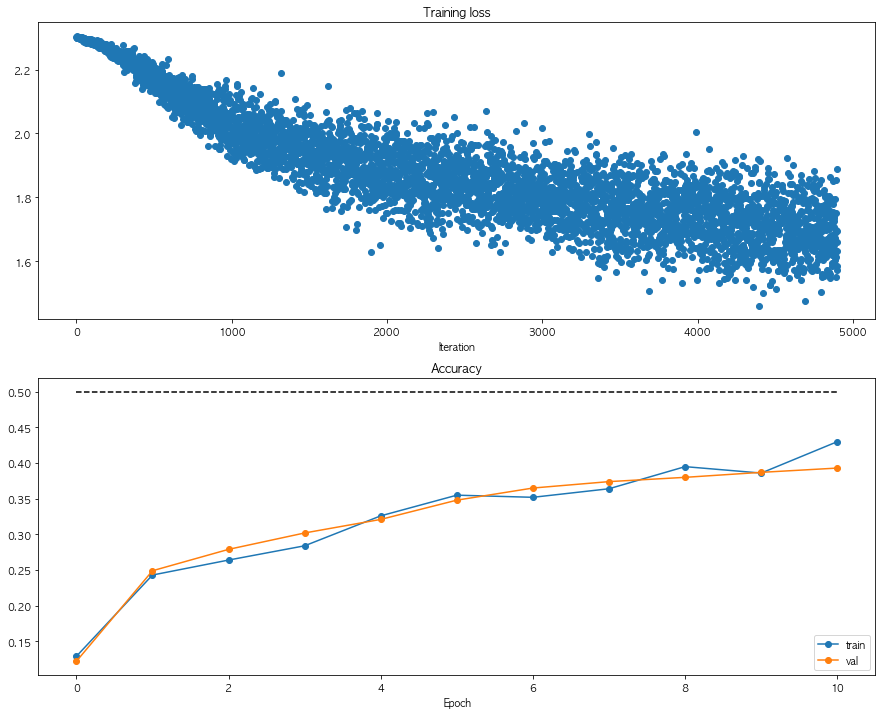

In [237]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

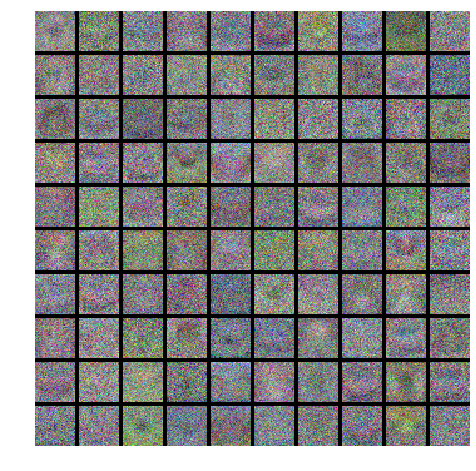

In [238]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

(9, 2)
-8.0 -7.333333333333333
============== learning_rate: 4.602967e-08 ===============
(Iteration 1 / 2450) loss: 2.299329
(Epoch 0 / 5) train acc: 0.109000; val_acc: 0.084000
(Epoch 1 / 5) train acc: 0.089000; val_acc: 0.084000
(Iteration 501 / 2450) loss: 2.301174
(Epoch 2 / 5) train acc: 0.101000; val_acc: 0.085000
(Iteration 1001 / 2450) loss: 2.300040
(Epoch 3 / 5) train acc: 0.082000; val_acc: 0.088000
(Iteration 1501 / 2450) loss: 2.304546
(Epoch 4 / 5) train acc: 0.101000; val_acc: 0.088000
(Iteration 2001 / 2450) loss: 2.301340
(Epoch 5 / 5) train acc: 0.110000; val_acc: 0.088000


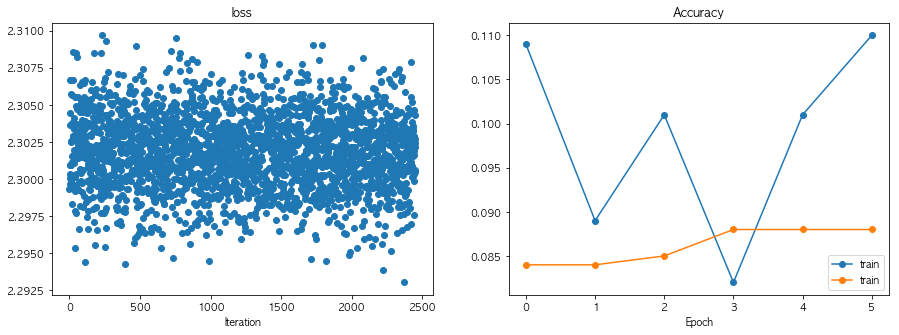

-7.333333333333333 -6.666666666666667
============== learning_rate: 7.097737e-08 ===============
(Iteration 1 / 2450) loss: 2.297853
(Epoch 0 / 5) train acc: 0.116000; val_acc: 0.116000
(Epoch 1 / 5) train acc: 0.112000; val_acc: 0.116000
(Iteration 501 / 2450) loss: 2.300653
(Epoch 2 / 5) train acc: 0.121000; val_acc: 0.117000
(Iteration 1001 / 2450) loss: 2.297742
(Epoch 3 / 5) train acc: 0.116000; val_acc: 0.118000
(Iteration 1501 / 2450) loss: 2.297849
(Epoch 4 / 5) train acc: 0.129000; val_acc: 0.119000
(Iteration 2001 / 2450) loss: 2.301356
(Epoch 5 / 5) train acc: 0.113000; val_acc: 0.121000


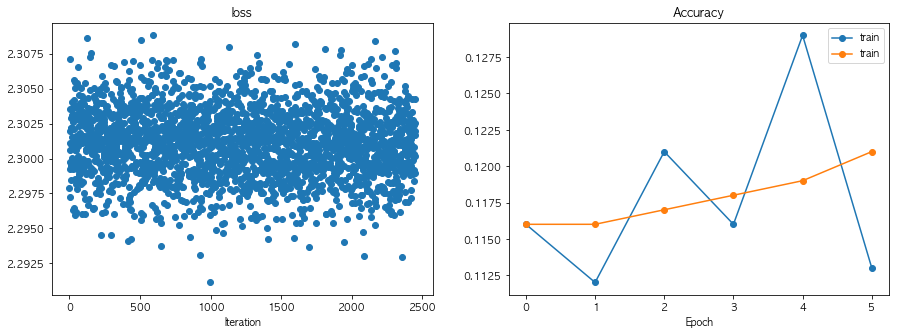

-6.666666666666667 -6.0
============== learning_rate: 3.335993e-07 ===============
(Iteration 1 / 2450) loss: 2.301816
(Epoch 0 / 5) train acc: 0.128000; val_acc: 0.135000
(Epoch 1 / 5) train acc: 0.112000; val_acc: 0.141000
(Iteration 501 / 2450) loss: 2.304554
(Epoch 2 / 5) train acc: 0.122000; val_acc: 0.144000
(Iteration 1001 / 2450) loss: 2.301356
(Epoch 3 / 5) train acc: 0.129000; val_acc: 0.148000
(Iteration 1501 / 2450) loss: 2.296463
(Epoch 4 / 5) train acc: 0.136000; val_acc: 0.156000
(Iteration 2001 / 2450) loss: 2.299045
(Epoch 5 / 5) train acc: 0.154000; val_acc: 0.171000


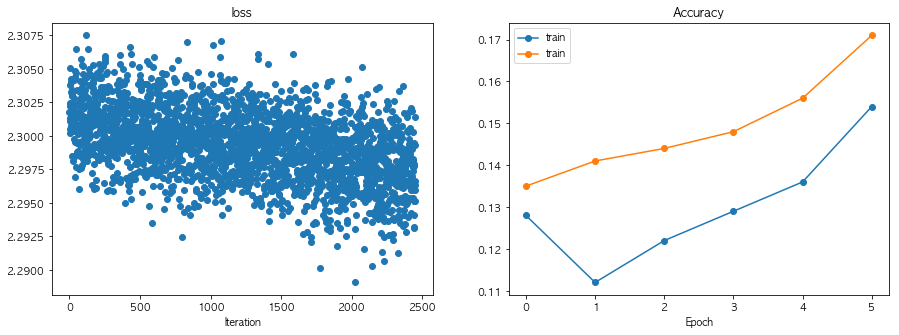

-6.0 -5.333333333333334
============== learning_rate: 3.995454e-06 ===============
(Iteration 1 / 2450) loss: 2.301162
(Epoch 0 / 5) train acc: 0.119000; val_acc: 0.122000
(Epoch 1 / 5) train acc: 0.163000; val_acc: 0.187000
(Iteration 501 / 2450) loss: 2.292191
(Epoch 2 / 5) train acc: 0.198000; val_acc: 0.228000
(Iteration 1001 / 2450) loss: 2.288989
(Epoch 3 / 5) train acc: 0.236000; val_acc: 0.246000
(Iteration 1501 / 2450) loss: 2.268168
(Epoch 4 / 5) train acc: 0.241000; val_acc: 0.250000
(Iteration 2001 / 2450) loss: 2.248668
(Epoch 5 / 5) train acc: 0.246000; val_acc: 0.246000


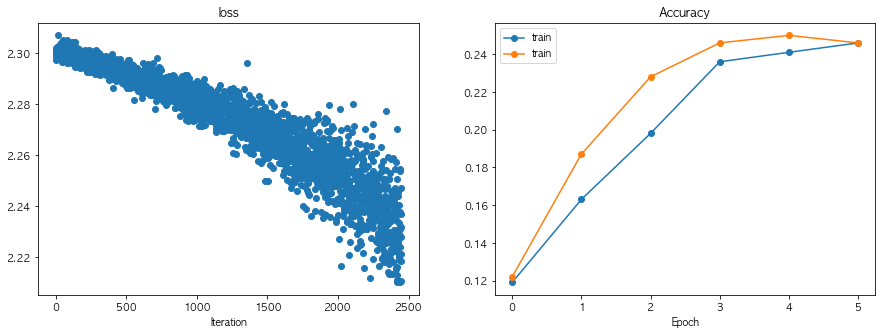

-5.333333333333334 -4.666666666666667
============== learning_rate: 1.970926e-05 ===============
(Iteration 1 / 2450) loss: 2.307415
(Epoch 0 / 5) train acc: 0.072000; val_acc: 0.075000
(Epoch 1 / 5) train acc: 0.278000; val_acc: 0.239000
(Iteration 501 / 2450) loss: 2.253817
(Epoch 2 / 5) train acc: 0.265000; val_acc: 0.270000
(Iteration 1001 / 2450) loss: 2.163863
(Epoch 3 / 5) train acc: 0.293000; val_acc: 0.279000
(Iteration 1501 / 2450) loss: 2.048774
(Epoch 4 / 5) train acc: 0.282000; val_acc: 0.293000
(Iteration 2001 / 2450) loss: 1.956692
(Epoch 5 / 5) train acc: 0.293000; val_acc: 0.314000


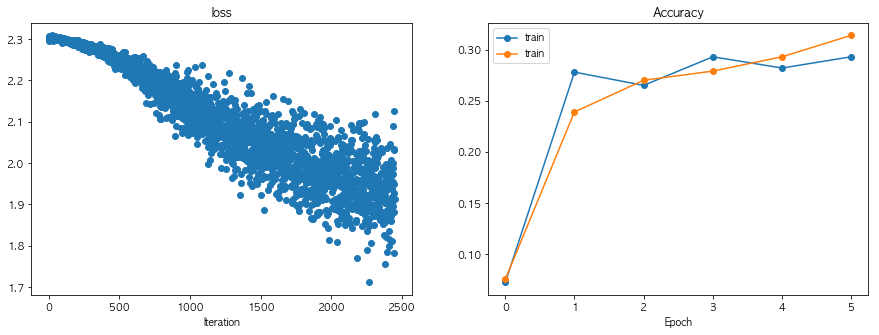

-4.666666666666667 -4.0
============== learning_rate: 7.904586e-05 ===============
(Iteration 1 / 2450) loss: 2.305489
(Epoch 0 / 5) train acc: 0.084000; val_acc: 0.100000
(Epoch 1 / 5) train acc: 0.274000; val_acc: 0.300000
(Iteration 501 / 2450) loss: 1.941817
(Epoch 2 / 5) train acc: 0.344000; val_acc: 0.358000
(Iteration 1001 / 2450) loss: 1.923018
(Epoch 3 / 5) train acc: 0.398000; val_acc: 0.397000
(Iteration 1501 / 2450) loss: 1.662888
(Epoch 4 / 5) train acc: 0.414000; val_acc: 0.414000
(Iteration 2001 / 2450) loss: 1.660624
(Epoch 5 / 5) train acc: 0.422000; val_acc: 0.445000


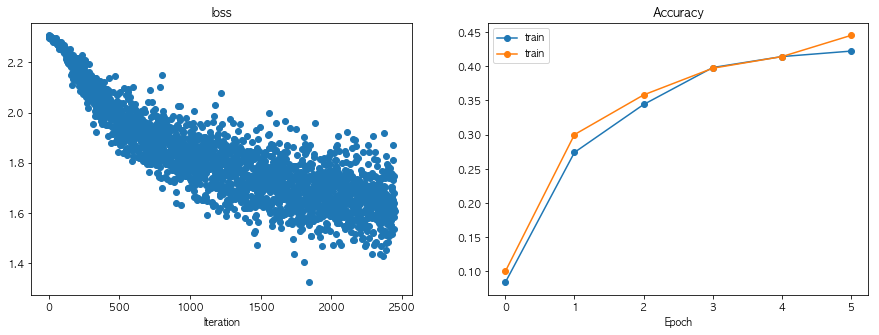

-4.0 -3.333333333333334
============== learning_rate: 2.747281e-04 ===============
(Iteration 1 / 2450) loss: 2.296237
(Epoch 0 / 5) train acc: 0.124000; val_acc: 0.112000
(Epoch 1 / 5) train acc: 0.408000; val_acc: 0.401000
(Iteration 501 / 2450) loss: 1.754885
(Epoch 2 / 5) train acc: 0.428000; val_acc: 0.454000
(Iteration 1001 / 2450) loss: 1.754262
(Epoch 3 / 5) train acc: 0.492000; val_acc: 0.476000
(Iteration 1501 / 2450) loss: 1.462668
(Epoch 4 / 5) train acc: 0.495000; val_acc: 0.482000
(Iteration 2001 / 2450) loss: 1.462054
(Epoch 5 / 5) train acc: 0.509000; val_acc: 0.510000


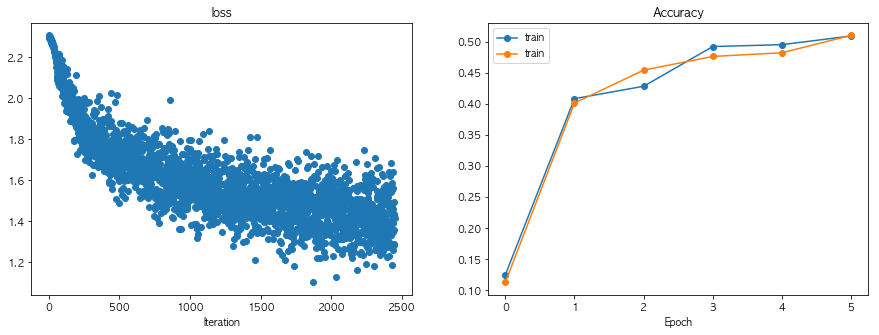

-3.333333333333334 -2.666666666666667
============== learning_rate: 6.150463e-04 ===============
(Iteration 1 / 2450) loss: 2.296585
(Epoch 0 / 5) train acc: 0.118000; val_acc: 0.143000
(Epoch 1 / 5) train acc: 0.453000; val_acc: 0.432000
(Iteration 501 / 2450) loss: 1.660436
(Epoch 2 / 5) train acc: 0.485000; val_acc: 0.441000
(Iteration 1001 / 2450) loss: 1.364276
(Epoch 3 / 5) train acc: 0.530000; val_acc: 0.493000
(Iteration 1501 / 2450) loss: 1.361047
(Epoch 4 / 5) train acc: 0.544000; val_acc: 0.494000
(Iteration 2001 / 2450) loss: 1.291938
(Epoch 5 / 5) train acc: 0.570000; val_acc: 0.506000


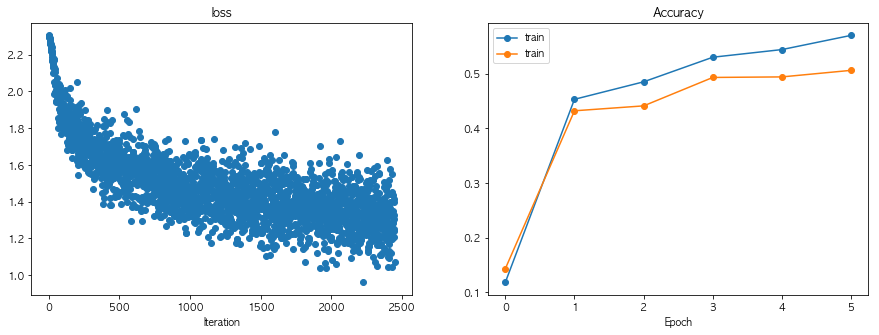

-2.666666666666667 -2.0
============== learning_rate: 6.735339e-03 ===============
(Iteration 1 / 2450) loss: 2.304900
(Epoch 0 / 5) train acc: 0.173000; val_acc: 0.189000
(Epoch 1 / 5) train acc: 0.100000; val_acc: 0.087000
(Iteration 501 / 2450) loss: nan
(Epoch 2 / 5) train acc: 0.103000; val_acc: 0.087000
(Iteration 1001 / 2450) loss: nan
(Epoch 3 / 5) train acc: 0.097000; val_acc: 0.087000
(Iteration 1501 / 2450) loss: nan
(Epoch 4 / 5) train acc: 0.107000; val_acc: 0.087000
(Iteration 2001 / 2450) loss: nan
(Epoch 5 / 5) train acc: 0.084000; val_acc: 0.087000


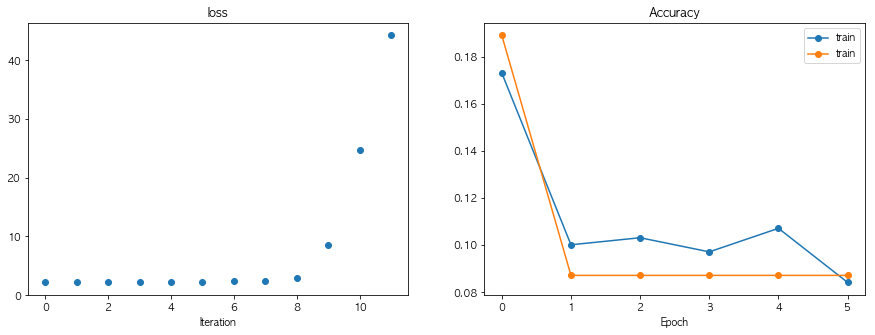

best info:  0.51 [-4.0, -3.333333333333334]
============== learning_rate: 1.469905e-04 ===============
(Iteration 1 / 4900) loss: 2.304365
(Epoch 0 / 10) train acc: 0.114000; val_acc: 0.098000
(Epoch 1 / 10) train acc: 0.348000; val_acc: 0.351000
(Iteration 501 / 4900) loss: 1.931776
(Epoch 2 / 10) train acc: 0.402000; val_acc: 0.417000
(Iteration 1001 / 4900) loss: 1.657098
(Epoch 3 / 10) train acc: 0.396000; val_acc: 0.452000
(Iteration 1501 / 4900) loss: 1.707370
(Epoch 4 / 10) train acc: 0.463000; val_acc: 0.464000
(Iteration 2001 / 4900) loss: 1.714485
(Epoch 5 / 10) train acc: 0.451000; val_acc: 0.461000
(Iteration 2501 / 4900) loss: 1.556706
(Epoch 6 / 10) train acc: 0.487000; val_acc: 0.472000
(Iteration 3001 / 4900) loss: 1.443031
(Epoch 7 / 10) train acc: 0.495000; val_acc: 0.473000
(Iteration 3501 / 4900) loss: 1.671608
(Epoch 8 / 10) train acc: 0.524000; val_acc: 0.487000
(Iteration 4001 / 4900) loss: 1.498461
(Epoch 9 / 10) train acc: 0.506000; val_acc: 0.489000
(Iteration

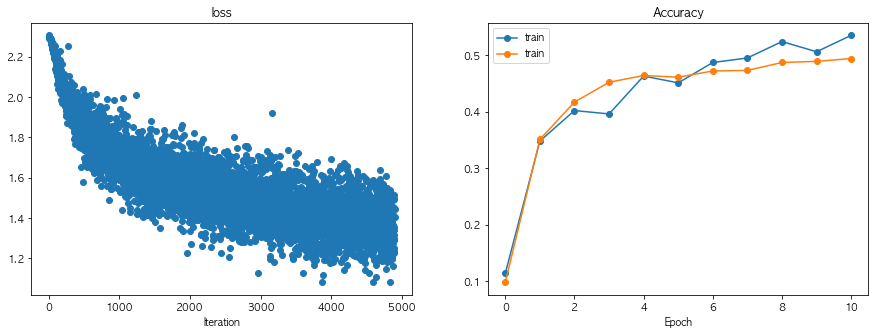

============== learning_rate: 1.210973e-04 ===============
(Iteration 1 / 4900) loss: 2.301604
(Epoch 0 / 10) train acc: 0.096000; val_acc: 0.086000
(Epoch 1 / 10) train acc: 0.333000; val_acc: 0.327000
(Iteration 501 / 4900) loss: 1.696306
(Epoch 2 / 10) train acc: 0.391000; val_acc: 0.386000
(Iteration 1001 / 4900) loss: 1.928723
(Epoch 3 / 10) train acc: 0.441000; val_acc: 0.433000
(Iteration 1501 / 4900) loss: 1.670639
(Epoch 4 / 10) train acc: 0.452000; val_acc: 0.453000
(Iteration 2001 / 4900) loss: 1.514862
(Epoch 5 / 10) train acc: 0.442000; val_acc: 0.442000
(Iteration 2501 / 4900) loss: 1.507945
(Epoch 6 / 10) train acc: 0.467000; val_acc: 0.458000
(Iteration 3001 / 4900) loss: 1.514120
(Epoch 7 / 10) train acc: 0.476000; val_acc: 0.461000
(Iteration 3501 / 4900) loss: 1.615787
(Epoch 8 / 10) train acc: 0.467000; val_acc: 0.486000
(Iteration 4001 / 4900) loss: 1.489373
(Epoch 9 / 10) train acc: 0.534000; val_acc: 0.479000
(Iteration 4501 / 4900) loss: 1.388941
(Epoch 10 / 10)

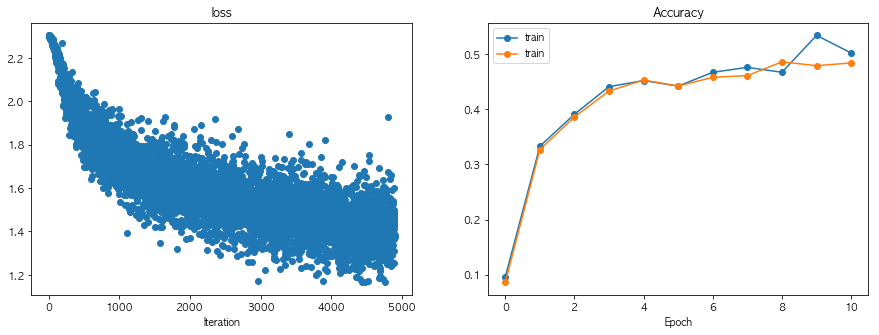

============== learning_rate: 1.074311e-04 ===============
(Iteration 1 / 4900) loss: 2.306700
(Epoch 0 / 10) train acc: 0.126000; val_acc: 0.109000
(Epoch 1 / 10) train acc: 0.312000; val_acc: 0.325000
(Iteration 501 / 4900) loss: 1.916176
(Epoch 2 / 10) train acc: 0.399000; val_acc: 0.381000
(Iteration 1001 / 4900) loss: 1.723995
(Epoch 3 / 10) train acc: 0.410000; val_acc: 0.430000
(Iteration 1501 / 4900) loss: 1.624221
(Epoch 4 / 10) train acc: 0.449000; val_acc: 0.442000
(Iteration 2001 / 4900) loss: 1.611032
(Epoch 5 / 10) train acc: 0.463000; val_acc: 0.459000
(Iteration 2501 / 4900) loss: 1.563696
(Epoch 6 / 10) train acc: 0.466000; val_acc: 0.470000
(Iteration 3001 / 4900) loss: 1.504877
(Epoch 7 / 10) train acc: 0.470000; val_acc: 0.483000
(Iteration 3501 / 4900) loss: 1.492375
(Epoch 8 / 10) train acc: 0.497000; val_acc: 0.467000
(Iteration 4001 / 4900) loss: 1.521866
(Epoch 9 / 10) train acc: 0.514000; val_acc: 0.486000
(Iteration 4501 / 4900) loss: 1.530824
(Epoch 10 / 10)

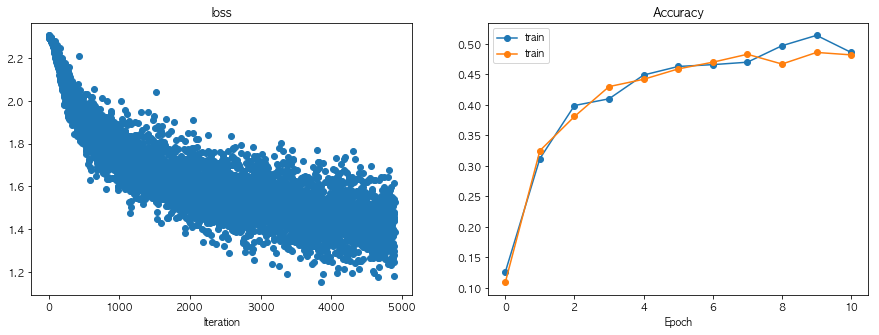

============== learning_rate: 4.104558e-04 ===============
(Iteration 1 / 4900) loss: 2.305070
(Epoch 0 / 10) train acc: 0.111000; val_acc: 0.102000
(Epoch 1 / 10) train acc: 0.426000; val_acc: 0.445000
(Iteration 501 / 4900) loss: 1.525142
(Epoch 2 / 10) train acc: 0.463000; val_acc: 0.445000
(Iteration 1001 / 4900) loss: 1.341849
(Epoch 3 / 10) train acc: 0.462000; val_acc: 0.468000
(Iteration 1501 / 4900) loss: 1.556400
(Epoch 4 / 10) train acc: 0.493000; val_acc: 0.475000
(Iteration 2001 / 4900) loss: 1.436833
(Epoch 5 / 10) train acc: 0.544000; val_acc: 0.487000
(Iteration 2501 / 4900) loss: 1.253632
(Epoch 6 / 10) train acc: 0.525000; val_acc: 0.492000
(Iteration 3001 / 4900) loss: 1.119792
(Epoch 7 / 10) train acc: 0.573000; val_acc: 0.500000
(Iteration 3501 / 4900) loss: 1.314771
(Epoch 8 / 10) train acc: 0.593000; val_acc: 0.522000
(Iteration 4001 / 4900) loss: 1.062926
(Epoch 9 / 10) train acc: 0.585000; val_acc: 0.498000
(Iteration 4501 / 4900) loss: 1.255701
(Epoch 10 / 10)

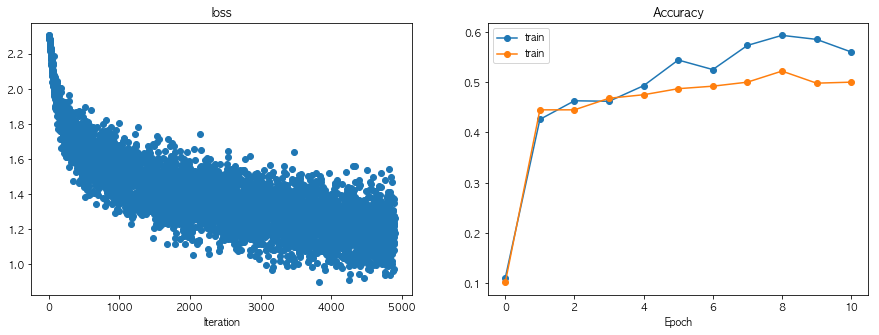

============== learning_rate: 3.790342e-04 ===============
(Iteration 1 / 4900) loss: 2.302824
(Epoch 0 / 10) train acc: 0.122000; val_acc: 0.143000
(Epoch 1 / 10) train acc: 0.414000; val_acc: 0.425000
(Iteration 501 / 4900) loss: 1.571774
(Epoch 2 / 10) train acc: 0.471000; val_acc: 0.456000
(Iteration 1001 / 4900) loss: 1.559992
(Epoch 3 / 10) train acc: 0.499000; val_acc: 0.483000
(Iteration 1501 / 4900) loss: 1.326660
(Epoch 4 / 10) train acc: 0.520000; val_acc: 0.473000
(Iteration 2001 / 4900) loss: 1.299724
(Epoch 5 / 10) train acc: 0.555000; val_acc: 0.491000
(Iteration 2501 / 4900) loss: 1.232191
(Epoch 6 / 10) train acc: 0.527000; val_acc: 0.505000
(Iteration 3001 / 4900) loss: 1.287788
(Epoch 7 / 10) train acc: 0.561000; val_acc: 0.491000
(Iteration 3501 / 4900) loss: 1.456559
(Epoch 8 / 10) train acc: 0.547000; val_acc: 0.530000
(Iteration 4001 / 4900) loss: 1.328793
(Epoch 9 / 10) train acc: 0.571000; val_acc: 0.518000
(Iteration 4501 / 4900) loss: 1.320528
(Epoch 10 / 10)

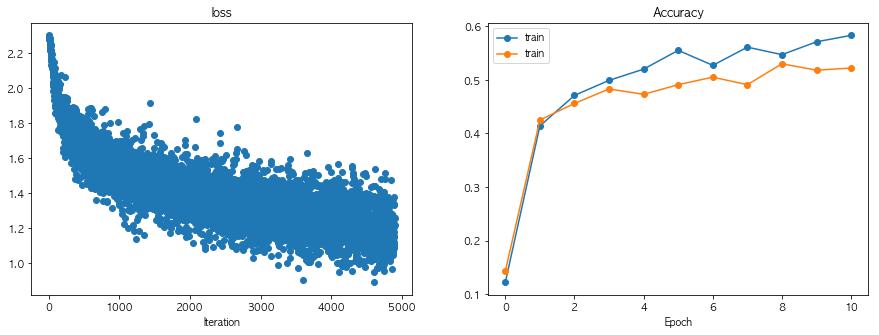

============== learning_rate: 1.669885e-04 ===============
(Iteration 1 / 4900) loss: 2.301791
(Epoch 0 / 10) train acc: 0.101000; val_acc: 0.106000
(Epoch 1 / 10) train acc: 0.370000; val_acc: 0.361000
(Iteration 501 / 4900) loss: 1.776520
(Epoch 2 / 10) train acc: 0.405000; val_acc: 0.418000
(Iteration 1001 / 4900) loss: 1.668013
(Epoch 3 / 10) train acc: 0.436000; val_acc: 0.459000
(Iteration 1501 / 4900) loss: 1.514662
(Epoch 4 / 10) train acc: 0.494000; val_acc: 0.479000
(Iteration 2001 / 4900) loss: 1.385413
(Epoch 5 / 10) train acc: 0.491000; val_acc: 0.482000
(Iteration 2501 / 4900) loss: 1.473969
(Epoch 6 / 10) train acc: 0.474000; val_acc: 0.486000
(Iteration 3001 / 4900) loss: 1.520105
(Epoch 7 / 10) train acc: 0.510000; val_acc: 0.486000
(Iteration 3501 / 4900) loss: 1.401109
(Epoch 8 / 10) train acc: 0.508000; val_acc: 0.485000
(Iteration 4001 / 4900) loss: 1.381080
(Epoch 9 / 10) train acc: 0.517000; val_acc: 0.488000
(Iteration 4501 / 4900) loss: 1.425736
(Epoch 10 / 10)

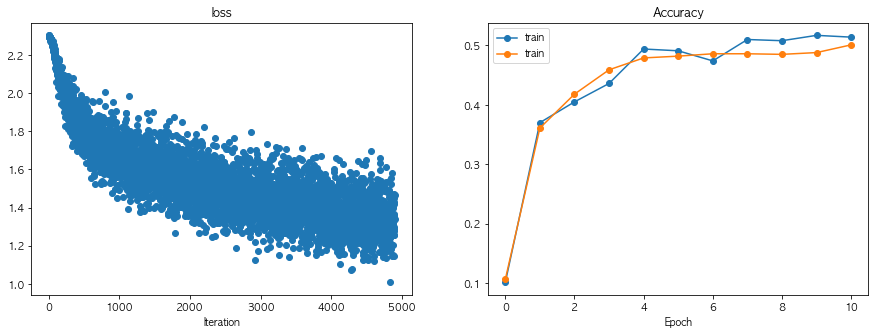

============== learning_rate: 1.314849e-04 ===============
(Iteration 1 / 4900) loss: 2.307197
(Epoch 0 / 10) train acc: 0.100000; val_acc: 0.101000
(Epoch 1 / 10) train acc: 0.334000; val_acc: 0.330000
(Iteration 501 / 4900) loss: 1.945169
(Epoch 2 / 10) train acc: 0.392000; val_acc: 0.387000
(Iteration 1001 / 4900) loss: 1.653131
(Epoch 3 / 10) train acc: 0.444000; val_acc: 0.432000
(Iteration 1501 / 4900) loss: 1.587841
(Epoch 4 / 10) train acc: 0.458000; val_acc: 0.438000
(Iteration 2001 / 4900) loss: 1.651575
(Epoch 5 / 10) train acc: 0.455000; val_acc: 0.454000
(Iteration 2501 / 4900) loss: 1.378329
(Epoch 6 / 10) train acc: 0.451000; val_acc: 0.477000
(Iteration 3001 / 4900) loss: 1.492442
(Epoch 7 / 10) train acc: 0.488000; val_acc: 0.474000
(Iteration 3501 / 4900) loss: 1.510036
(Epoch 8 / 10) train acc: 0.501000; val_acc: 0.479000
(Iteration 4001 / 4900) loss: 1.421108
(Epoch 9 / 10) train acc: 0.508000; val_acc: 0.478000
(Iteration 4501 / 4900) loss: 1.397404
(Epoch 10 / 10)

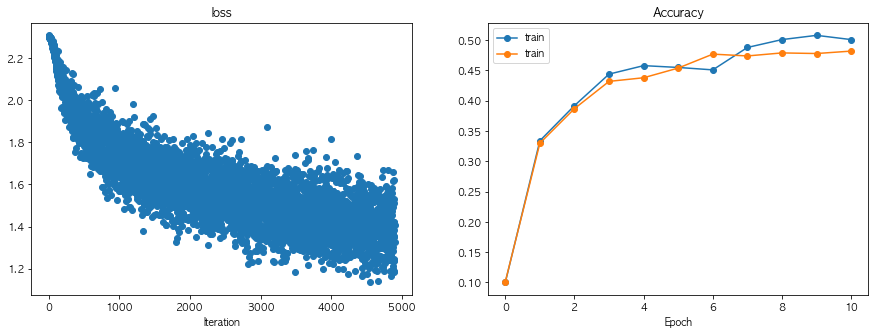

============== learning_rate: 1.038118e-04 ===============
(Iteration 1 / 4900) loss: 2.303514
(Epoch 0 / 10) train acc: 0.086000; val_acc: 0.077000
(Epoch 1 / 10) train acc: 0.318000; val_acc: 0.322000
(Iteration 501 / 4900) loss: 1.881978
(Epoch 2 / 10) train acc: 0.377000; val_acc: 0.388000
(Iteration 1001 / 4900) loss: 1.716864
(Epoch 3 / 10) train acc: 0.385000; val_acc: 0.411000
(Iteration 1501 / 4900) loss: 1.639909
(Epoch 4 / 10) train acc: 0.446000; val_acc: 0.438000
(Iteration 2001 / 4900) loss: 1.709198
(Epoch 5 / 10) train acc: 0.414000; val_acc: 0.458000
(Iteration 2501 / 4900) loss: 1.478525
(Epoch 6 / 10) train acc: 0.438000; val_acc: 0.472000
(Iteration 3001 / 4900) loss: 1.470047
(Epoch 7 / 10) train acc: 0.476000; val_acc: 0.475000
(Iteration 3501 / 4900) loss: 1.522645
(Epoch 8 / 10) train acc: 0.478000; val_acc: 0.485000
(Iteration 4001 / 4900) loss: 1.514723
(Epoch 9 / 10) train acc: 0.480000; val_acc: 0.481000
(Iteration 4501 / 4900) loss: 1.341583
(Epoch 10 / 10)

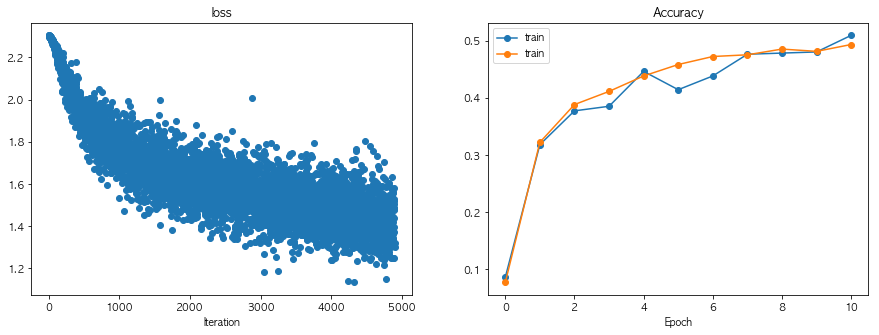

============== learning_rate: 1.852892e-04 ===============
(Iteration 1 / 4900) loss: 2.302325
(Epoch 0 / 10) train acc: 0.109000; val_acc: 0.100000
(Epoch 1 / 10) train acc: 0.346000; val_acc: 0.368000
(Iteration 501 / 4900) loss: 1.875435
(Epoch 2 / 10) train acc: 0.403000; val_acc: 0.430000
(Iteration 1001 / 4900) loss: 1.836007
(Epoch 3 / 10) train acc: 0.453000; val_acc: 0.462000
(Iteration 1501 / 4900) loss: 1.547953
(Epoch 4 / 10) train acc: 0.464000; val_acc: 0.479000
(Iteration 2001 / 4900) loss: 1.590322
(Epoch 5 / 10) train acc: 0.494000; val_acc: 0.468000
(Iteration 2501 / 4900) loss: 1.754817
(Epoch 6 / 10) train acc: 0.501000; val_acc: 0.464000
(Iteration 3001 / 4900) loss: 1.293659
(Epoch 7 / 10) train acc: 0.500000; val_acc: 0.468000
(Iteration 3501 / 4900) loss: 1.382766
(Epoch 8 / 10) train acc: 0.553000; val_acc: 0.493000
(Iteration 4001 / 4900) loss: 1.381493
(Epoch 9 / 10) train acc: 0.549000; val_acc: 0.495000
(Iteration 4501 / 4900) loss: 1.379403
(Epoch 10 / 10)

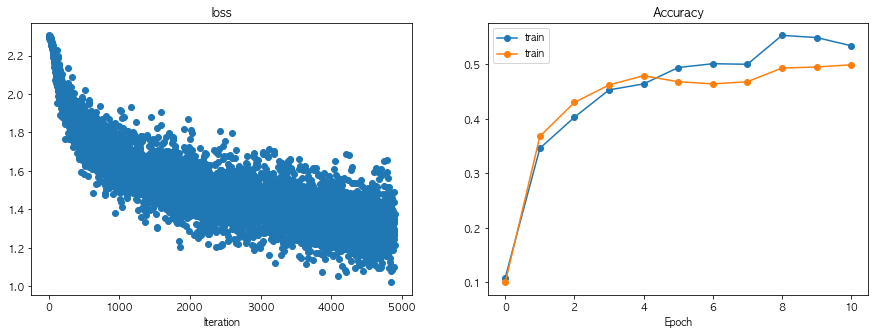

============== learning_rate: 1.123374e-04 ===============
(Iteration 1 / 4900) loss: 2.306306
(Epoch 0 / 10) train acc: 0.095000; val_acc: 0.092000
(Epoch 1 / 10) train acc: 0.337000; val_acc: 0.320000
(Iteration 501 / 4900) loss: 1.904558
(Epoch 2 / 10) train acc: 0.373000; val_acc: 0.381000
(Iteration 1001 / 4900) loss: 1.829834
(Epoch 3 / 10) train acc: 0.372000; val_acc: 0.418000
(Iteration 1501 / 4900) loss: 1.495886
(Epoch 4 / 10) train acc: 0.436000; val_acc: 0.444000
(Iteration 2001 / 4900) loss: 1.670405
(Epoch 5 / 10) train acc: 0.453000; val_acc: 0.459000
(Iteration 2501 / 4900) loss: 1.537806
(Epoch 6 / 10) train acc: 0.463000; val_acc: 0.468000
(Iteration 3001 / 4900) loss: 1.710277
(Epoch 7 / 10) train acc: 0.481000; val_acc: 0.469000
(Iteration 3501 / 4900) loss: 1.313082
(Epoch 8 / 10) train acc: 0.501000; val_acc: 0.495000
(Iteration 4001 / 4900) loss: 1.457353
(Epoch 9 / 10) train acc: 0.449000; val_acc: 0.485000
(Iteration 4501 / 4900) loss: 1.222102
(Epoch 10 / 10)

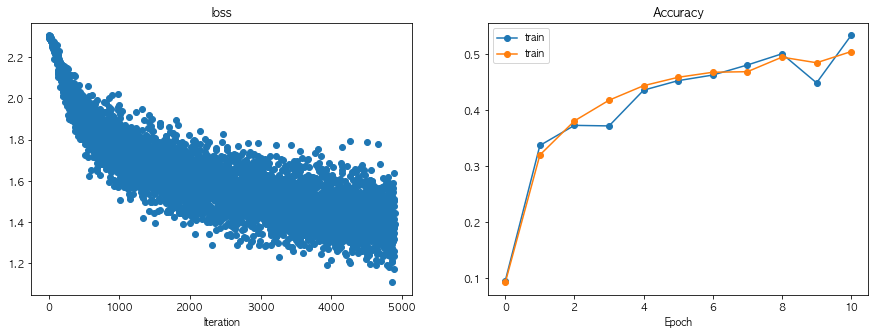

best info:  0.53 [-2.666666666666667, -2.0] 0.00011233737191944731


In [267]:
best_model = None

#? hidden layer size
#? learning rate
#? training epoch num
#? regularization strength
#? learning rate decay (but it can be able to get performance using the default value)

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#! initialization
print_every=500

#! plot solver's accuracy
def plot_accuracy(loss_history, train_acc_history, val_acc_history):
    plt.subplot(1, 2, 1)
    plt.title("loss")
    plt.plot(loss_history, 'o')
    plt.xlabel("Iteration")

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_acc_history, '-o', label='train')
    plt.plot(val_acc_history, '-o', label='train')
    plt.xlabel("Epoch")
    plt.legend()
    plt.gcf().set_size_inches(15, 5)
    plt.show() 

#! coarse learning tuning
#? prolog
reg = 0.001
hidden_size = 50
num_epochs = 5
val_data = {k: v for k, v in train_val_data.items() if k in ['X_val', 'y_val']}

#? stratified sampling - (1) separately divided bins. -> (2) uniformly random sampling of each bin
#* (1) separately divided bins
num_bins=10
lr_range=np.linspace(-8, -2, num=num_bins)
bins=[]
for idx in np.arange(num_bins):
    if idx == num_bins-1: break
    bins.append([lr_range[idx], lr_range[idx+1]])
print(np.shape(bins))

#* (2) uniformly random sampling of each bin
best_bin = []
best_acc = 0.
for bin in bins:
    s, e = bin
    print(s, e)
    learning_rate = 10 ** np.random.uniform(s, e)
    print('============== learning_rate: %e ===============' % (learning_rate))
    model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
    solver = Solver(model, data, optim_config={'learning_rate': learning_rate}, print_every=print_every, num_epochs=num_epochs)
    solver.train()
    val_acc = solver.check_accuracy(val_data['X_val'], val_data['y_val'])
    plot_accuracy(solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    if best_acc < val_acc:
        best_acc = val_acc
        best_model = model
        best_bin = bin

print('best info: ', best_acc, best_bin)

#! fine learning rate tuning
max_count=10
num_epochs=10
best_learning_rate = 0.
s, e = best_bin
for count in range(max_count):
    learning_rate = 10 ** np.random.uniform(s, e)
    print('============== learning_rate: %e ===============' % (learning_rate))
    model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
    solver = Solver(model, data, optim_config={'learning_rate': learning_rate}, print_every=print_every, num_epochs=num_epochs)
    solver.train()
    val_acc = solver.check_accuracy(val_data['X_val'], val_data['y_val'])
    plot_accuracy(solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    if best_acc < val_acc:
        best_acc = val_acc
        best_model = model
        best_bin = bin
        best_learning_rate = learning_rate

print('best info: ', best_acc, best_bin, learning_rate)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [268]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.53


In [269]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.522


## Inline Question 2: 

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

$\color{blue}{\textit Your Explanation:}$

